In [35]:
# Import packages and set up directory

import os
from glob import glob
import warnings
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr
import requests
import xrspatial
import matplotlib.pyplot as plt
import earthpy.plot as ep

# Assign variable to coordiate system for use
utm_epsg = 32614

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME)
grass_dir = os.path.join(data_dir, 'grassland-sites')

for a_dir in [grass_dir]:
        if not os.path.exists(a_dir):
                os.makedirs(a_dir)

In [18]:
# Create a path
grass_path = os.path.join(grass_dir, 'grassland.shp')

# Read in URL
if not os.path.exists(grass_path):
    grass_url = (
        'https://data.fs.usda.gov/geodata/edw/edw_resources/'
        'shp/S_USA.NationalGrassland.zip')
    gpd.read_file(grass_url).to_file(grass_path)

# Read file as a geodataframe
grass_gdf = (
    gpd.read_file(grass_path)
    .to_crs(utm_epsg))

# Create geodataframe for specific grassland
pawnee_gdf = (
    grass_gdf
    .set_index('GRASSLANDN')
    .to_crs(utm_epsg)
     .loc[['Pawnee National Grassland']]
)

In [19]:
# Soil variable urls

pawnee_soil_url = ('http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/'
                   'v1.0/ph/mean/0_5/lat4041_lon-104-103.tif')

pawnee_soil_url_1 = ('http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/'
                     'v1.0/ph/mean/0_5/lat4041_lon-105-104.tif')

# Open soil rasters

pawnee_soil = rxr.open_rasterio(pawnee_soil_url, masked=True).squeeze()

pawnee_soil_1 = rxr.open_rasterio(pawnee_soil_url_1, masked=True).squeeze()

In [20]:
# Merge the Pawnee soil rasters

pawnee_soil_list = [pawnee_soil, pawnee_soil_1]
pawnee_soil_merge = (
    rxrmerge.merge_arrays(pawnee_soil_list)
    .rio.reproject(utm_epsg)
    .rio.clip_box(*pawnee_gdf.total_bounds))

# Overlay the grassland and soil raster
# pawnee_soil_merge.hvplot() * pawnee_gdf.hvplot(color=None, line_color='white')

In [21]:
# Initialize AppeearsDownloader for MODIS elevation data in Sheyenne

elev_downloader = etapp.AppeearsDownloader(
    download_key="pawnee_SRTM_DEM",
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11-2000",
    end_date="02-21-2000",
    polygon=pawnee_gdf)

# Download files if the download directory does not exist

if not os.path.exists(os.path.join(elev_downloader.data_dir, 'SRTMGL1-NUMNC-003-SRTMGL1-NUM-Statistics-QA.csv')):
    elev_downloader.download_files()

elev_downloader

In [22]:
# Merge arrays and reproject elevation

elev_paths = glob(
    os.path.join(
        elev_downloader.data_dir,
        'SRTMGL1_NC.003*',
        '*.tif'))
elev_da = (
    rxrmerge.merge_arrays(
        [rxr.open_rasterio(elev_path, masked=True).squeeze()
         for elev_path
         in elev_paths])
         .rio.reproject_match(pawnee_soil_merge)
)

In [23]:
# Calculate aspect for Pawnee

pawnee_aspect = xrspatial.aspect(elev_da)
# pawnee_aspect.hvplot(x='x', y='y', colormap='colorwheel')

In [24]:
# Download the Climatology Data for RCP 4.5

if not os.path.exists('maca_45.nc'):
    maca_45_url = (
        "http://thredds.northwestknowledge.net:8080/thredds/ncss/"
        "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
        "?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1"
        "&time_start=2050-01-15T00%3A00%3A00Z"
        "&time_end=2050-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf")

    maca_response = requests.get(maca_45_url)

    with open('maca_45.nc', 'wb') as maca_file:
        maca_file.write(maca_response.content)

In [25]:
# Data manipulation for Pawnee
maca_45_ds = xr.open_dataset('maca_45.nc')
# Reassign the Coordinates to match other datasets
maca_45_ds = maca_45_ds.assign_coords(lon=maca_45_ds.lon-360)
# Pull precipitation variable
precip_45_ds = maca_45_ds.precipitation
# Write the CRS
precip_45_ds.rio.write_crs("epsg:4326", inplace=True)
# Setting spatial dimensions
precip_45_ds.rio.set_spatial_dims('lon', 'lat', inplace=True)
# Reproject
precip_45_ds = precip_45_ds.rio.reproject_match(pawnee_soil_merge)
# Clip for Pawnee
precip_45_clip = precip_45_ds.rio.clip_box(*pawnee_gdf.total_bounds).mean('time')
# Plot the data
#precip_45_clip.hvplot(rasterize=True) * pawnee_gdf.hvplot(color='None')

In [26]:
# Download the Climatology Data for RCP 8.5

if not os.path.exists('maca_85.nc'):
    maca_85_url = (
        "http://thredds.northwestknowledge.net:8080/thredds/ncss/"
        "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85_2006_2099_CONUS_monthly.nc"
        "?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1"
        "&time_start=2050-01-15T00%3A00%3A00Z&time_end=2050-12-15T00%3A00%3A00Z"
        "&timeStride=1&accept=netcdf"
    )

    maca_response = requests.get(maca_85_url)

    with open('maca_85.nc', 'wb') as maca_file:
        maca_file.write(maca_response.content)

In [27]:
# Data manipulation for RCP 8.5
maca_85_ds = xr.open_dataset('maca_85.nc')
# Reassign the Coordinates to match other datasets
maca_85_ds = maca_85_ds.assign_coords(lon=maca_85_ds.lon-360)
# Pull precipitation variable
precip_85_ds = maca_85_ds.precipitation
# Write the CRS
precip_85_ds.rio.write_crs("epsg:4326", inplace=True)
# Setting spatial dimensions
precip_85_ds.rio.set_spatial_dims('lon', 'lat', inplace=True)
# Reproject
precip_85_ds = precip_85_ds.rio.reproject_match(pawnee_soil_merge)
# Clip to Pawnee
precip_85_clip = precip_85_ds.rio.clip_box(*pawnee_gdf.total_bounds).mean('time')
# Plot the data
#precip_85_clip.hvplot(rasterize=True) * pawnee_gdf.hvplot(color=None)

In [28]:
# Fuzzy Logic Model

# Assign a value of 1 to aspect for favorable conditions
p_rescale = xr.where(pawnee_aspect > 180, pawnee_aspect - 180, pawnee_aspect)
final_scale = (p_rescale) / (180)

In [29]:
# Assign a value of 1 to pH for favorable conditions
ph_rescale = xr.where(pawnee_soil_merge > 6.5, 6.5 + (6.5 - pawnee_soil_merge), pawnee_soil_merge)
final_ph_scale = (ph_rescale - ph_rescale.min()) / (ph_rescale.max() - ph_rescale.min())

In [30]:
# Assign a value of 1 to precip for favorable conditions
precip_rescale_45 = xr.where(precip_45_clip > 24, 24 + (24 - precip_45_clip), precip_45_clip)
final_precip_scale_45 = (precip_rescale_45 - precip_rescale_45.min()) / (24 - precip_rescale_45.min())

precip_rescale_85 = xr.where(precip_85_clip > 24, 24 + (24 - precip_85_clip), precip_85_clip)
final_precip_scale_85 = (precip_rescale_85 - precip_rescale_85.min()) / (24 - precip_rescale_85.min())

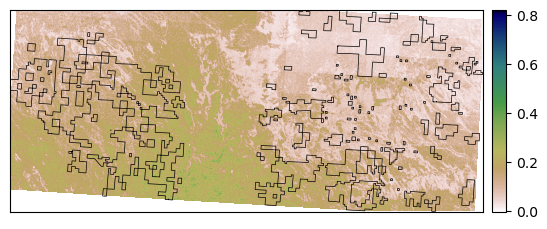

In [50]:
# Final Model for RCP 4.5- uncomment last line to see plot

model_45 = final_precip_scale_45 * final_ph_scale * final_scale
model_45 = model_45.rio.write_crs(utm_epsg)
model_45_clip = model_45.rio.clip(pawnee_gdf.geometry)
#model_45_clip.hvplot() * pawnee_gdf.hvplot(color=None)

# Plotting with matplotlib to save space (was having an issue uploading with hvplot because of file size being too big)
pawnee_extent = plotting_extent(model_45.values, model_45.rio.transform())
fig, ax = plt.subplots()
ep.plot_bands(model_45, ax=ax, extent=pawnee_extent, cmap='gist_earth_r')
pawnee_gdf.boundary.plot(ax=ax, color='black', linewidth=.5)
plt.show()

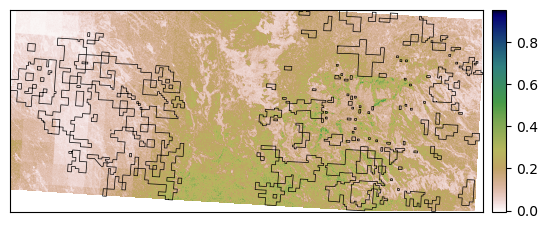

In [51]:
# Final Model for RCP 8.5- uncomment last line to see plot

model_85 = final_precip_scale_85 * final_ph_scale * final_scale
model_85 = model_85.rio.write_crs(utm_epsg)
model_85_clip = model_85.rio.clip(pawnee_gdf.geometry)
# model_85_clip.hvplot() * pawnee_gdf.hvplot(color=None)

# Plotting with matplotlib to save space (was having an issue uploading with hvplot because of file size being too big)
pawnee_extent = plotting_extent(model_85.values, model_85.rio.transform())
fig, ax = plt.subplots()
ep.plot_bands(model_85, ax=ax, extent=pawnee_extent, cmap='gist_earth_r')
pawnee_gdf.boundary.plot(ax=ax, color='black', linewidth=.5)
plt.show()